# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for random $k$-regular graphs with $k=8$.

Compare the steady-state magnetization with its equilibrium value.

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings
using Measurements: value;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [2]:
include("../../telegram/notifications.jl");

In [204]:
T = 20         # final time
k = 3          # degree
m⁰ = 0.5       # magnetization at time zero

β = 100.0
J = -1.0
h = 0.0;

In [263]:
p = 0.25
wᵢ = fill(DampedFactor(HomogeneousGlauberFactor(J, h, β), p), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [264]:
matrix_sizes = [16, 20, 23]
maxiters = fill(8, length(matrix_sizes))
maxiters = [8, 10, 20]
iters = zeros(Int, length(maxiters))
tol = 1e-4
for i in eachindex(maxiters)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol, damp=0.5)
end

Running MPBP: iter 32 	 Time: 0:14:15
  Δ:                8.520585218496635e-5
  SVD Matrix size:  23

In [207]:
@telegram "antiferro zeroT damped";

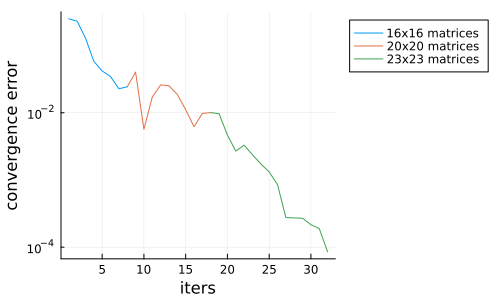

In [265]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

In [280]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m = means(spin, bp);

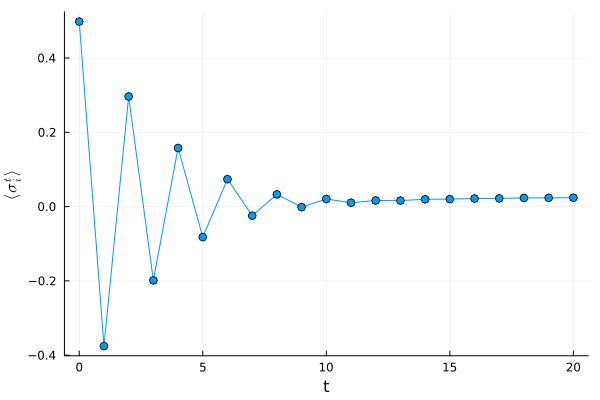

In [281]:
plot(0:T, mean(m), label="", ylabel=L"\langle \sigma_i^t\rangle", xlabel="t", m=:o)

In [282]:
pb, = pair_beliefs(bp)
r = [[expectation(spin, bb) for bb in b] for b in pb];

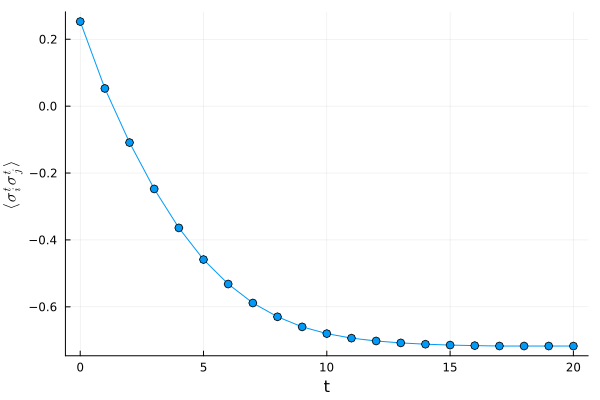

In [283]:
plot(0:T, mean(r), label="", ylabel=L"\langle \sigma_i^t \sigma_j^t\rangle", xlabel="t", m=:o)

### Compare with Monte Carlo on finite graphs

In [ ]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
T_mc = 40
wᵢ_mc = fill(DampedFactor(HomogeneousGlauberFactor(J, h, β), p), T_mc+1)
ϕᵢ_mc = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T_mc]
bp_mc = mpbp(IndexedBiDiGraph(g), fill(wᵢ_mc, N), fill(2,N), T_mc; ϕ = fill(ϕᵢ_mc, N))
sms = SoftMarginSampler(bp_mc);

In [ ]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

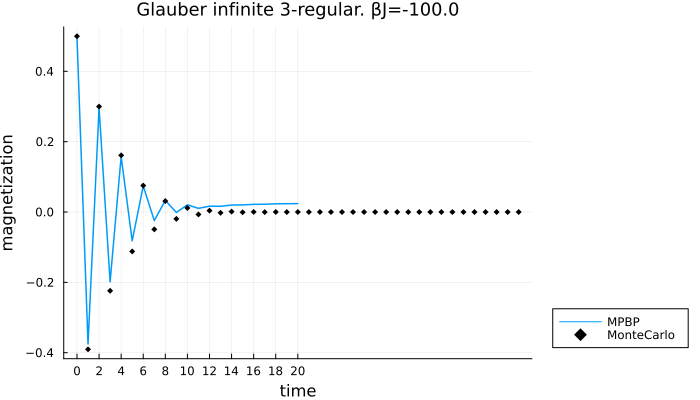

In [284]:
blue = theme_palette(:auto)[1]
skip_odd = false
step = skip_odd ? 2 : 1
pl = plot(0:step:T, m[1:step:end], xlabel="time", ylabel="magnetization", label="MPBP",
    size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular. βJ=$(β*J)", titlefontsize=12,
    legend=:outerbottomright, msc=:auto, c=blue, lw=1.5)
# plot!(pl, 0:T, sample(m_mc, 10^2), label=permutedims(["samples"; fill("", 10^2-1)]), c=:gray, la=0.1)
plot!(pl, 0:step:T_mc, mean(m_mc)[1:step:end], label="MonteCarlo", c=:black, m=:diamond, ms=3, msc=:auto, st=:scatter)

plot!(pl, size=(700, 400))

In [ ]:
pb_mc = pair_marginals(sms);

In [ ]:
r_mc = [[expectation(spin, value.(bb)) for bb in b] for b in pb_mc];

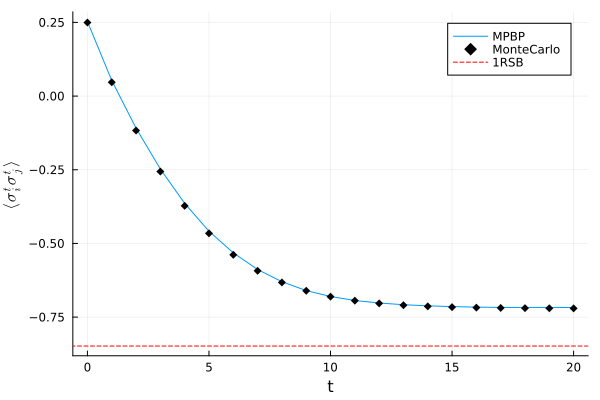

In [285]:
plot(0:T, mean(r), label="MPBP", ylabel=L"\langle \sigma_i^t \sigma_j^t\rangle", xlabel="t")
scatter!(0:T, mean(r_mc)[1:T+1], label="MonteCarlo", c=:black, m=:diamond, legend=:bottomright)
hline!([-1.27231/1.5], c=:red, ls=:dash, label="1RSB", legend=:topright)

In [274]:
c = autocovariances(bp);

In [275]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, ΔT=1.0, 
        us=0:(2*floor(Int, T/10)):T, kw...)
    step = skip_even ? 2 : 1
    cg = cgrad(:matter, length(us)+1, categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{s}\rangle-\langle x_{i}^t\rangle\langle x_{i}^{s}\rangle"
    xlabel = L"t-s"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, (u:-step:1).*ΔT, c[(0:step:u-1) .+ 1,u+1], label="t=$(Int(u*ΔT))", #label="t+Δt=$(Int(u*ΔT))", 
            c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

plot_autocovs! (generic function with 1 method)

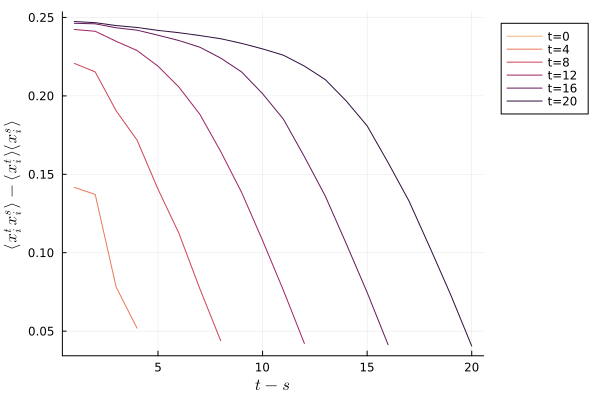

In [276]:
plot_autocovs(mean(c))

In [279]:
jldsave("plot_data/glauber_antiferro_zeroT.jld2"; T, J, k, β, N, m⁰, r, r_mc, c);